In [2]:
# Cellule 1 — Setup
import os, gc, time, random, numpy as np, tensorflow as tf
from tensorflow.keras import mixed_precision

SEED = 1337
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

for g in tf.config.list_physical_devices('GPU'):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass
tf.keras.backend.clear_session(); gc.collect()

if tf.config.list_physical_devices('GPU'):
    mixed_precision.set_global_policy("mixed_float16")

print("TF:", tf.__version__)
print("GPU dispo ?", len(tf.config.list_physical_devices('GPU')) > 0)
print("Policy:", mixed_precision.global_policy())


TF: 2.18.0
GPU dispo ? True
Policy: <DTypePolicy "mixed_float16">


In [3]:
# Cellule 2 — Config & chemins
DATA_DIR = "/kaggle/input/stanford-dogs-dataset/images/Images"
assert os.path.isdir(DATA_DIR), f"Chemin introuvable: {DATA_DIR}"

IMG_SIZE   = (320, 320)   # ↑ à (384,384) si VRAM OK
BATCH_SIZE = 8            # ↑ à 16 si VRAM OK
VAL_SPLIT  = 0.2
SEED       = 1337
PREFETCH   = 2            # plus sobre que AUTOTUNE

BACKBONE = "effv2s"       # "effv2s" ou "effb3" (fallback plus léger)


In [4]:
# Cellule 3 — Datasets (train/val)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, validation_split=VAL_SPLIT, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, validation_split=VAL_SPLIT, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)

train_ds = train_ds.shuffle(1024).prefetch(PREFETCH)
val_ds   = val_ds.prefetch(PREFETCH)

print("Nb classes:", num_classes)
print("les classes sont :",class_names)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


I0000 00:00:1757012058.434506      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757012058.435202      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Nb classes: 120
les classes sont : ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terri

In [19]:
# Export the class names used for training so the Flask app and plots show readable labels
# This writes the exact ordering used during training to class_names.txt
with open("class_names.txt", "w", encoding="utf-8") as f:
    for name in class_names:
        f.write(name + "\n")
print("Wrote class_names.txt with", len(class_names), "entries")

# Helper to make names human-readable (remove synset prefix, replace underscores)
def prettify(name: str) -> str:
    if name is None:
        return ""
    if '-' in name:
        name = name.split('-', 1)[1]
    return name.replace('_', ' ').title()

# Show a small sample
print("Sample prettified names:", [prettify(n) for n in class_names[:120]])


Wrote class_names.txt with 120 entries
Sample prettified names: ['Chihuahua', 'Japanese Spaniel', 'Maltese Dog', 'Pekinese', 'Shih-Tzu', 'Blenheim Spaniel', 'Papillon', 'Toy Terrier', 'Rhodesian Ridgeback', 'Afghan Hound', 'Basset', 'Beagle', 'Bloodhound', 'Bluetick', 'Black-And-Tan Coonhound', 'Walker Hound', 'English Foxhound', 'Redbone', 'Borzoi', 'Irish Wolfhound', 'Italian Greyhound', 'Whippet', 'Ibizan Hound', 'Norwegian Elkhound', 'Otterhound', 'Saluki', 'Scottish Deerhound', 'Weimaraner', 'Staffordshire Bullterrier', 'American Staffordshire Terrier', 'Bedlington Terrier', 'Border Terrier', 'Kerry Blue Terrier', 'Irish Terrier', 'Norfolk Terrier', 'Norwich Terrier', 'Yorkshire Terrier', 'Wire-Haired Fox Terrier', 'Lakeland Terrier', 'Sealyham Terrier', 'Airedale', 'Cairn', 'Australian Terrier', 'Dandie Dinmont', 'Boston Bull', 'Miniature Schnauzer', 'Giant Schnauzer', 'Standard Schnauzer', 'Scotch Terrier', 'Tibetan Terrier', 'Silky Terrier', 'Soft-Coated Wheaten Terrier', 'West

In [5]:
# Cellule 4 — Augmentations & preprocess
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effv2_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.10),
        layers.RandomTranslation(0.08, 0.08),
        layers.RandomContrast(0.15),
    ],
    name="augmentation",
)


In [6]:
# Cellule 5 — Modèle
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetB3

def build_model(backbone="effv2s", input_shape=(320,320,3), num_classes=120, train_base=False, dropout=0.4):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    if backbone == "effv2s":
        x = effv2_preprocess(x)
        base = EfficientNetV2S(input_shape=input_shape, include_top=False, weights="imagenet")
    else:
        x = eff_pre(x)
        base = EfficientNetB3(input_shape=input_shape, include_top=False, weights="imagenet")

    base.trainable = train_base
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # stabilité en mixed fp16
    model = keras.Model(inputs, outputs, name=f"{backbone}_transfer")
    return model, base

# Build
model, base = build_model(BACKBONE, IMG_SIZE + (3,), num_classes, train_base=False, dropout=0.4)
model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "effv2s_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 10, 10, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,485,080 (78.14 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [7]:
# Cellule 6 — Head training (backbone gelé)
from tensorflow.keras.optimizers import AdamW

EPOCHS_HEAD = 5
LR_HEAD     = 1e-3

model.compile(
    optimizer=AdamW(learning_rate=LR_HEAD, weight_decay=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ckpt_head = "/kaggle/working/head_best.keras"
callbacks_head = [
    keras.callbacks.ModelCheckpoint(ckpt_head, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6, verbose=1),
]

t0 = time.time()
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks_head,
    verbose=1
)
print(f"Temps head: {(time.time()-t0)/60:.1f} min | Best val_acc: {max(history_head.history['val_accuracy']):.4f}")


Epoch 1/5


I0000 00:00:1757012127.716543     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7560 - loss: 1.4380
Epoch 1: val_accuracy improved from -inf to 0.93853, saving model to /kaggle/working/head_best.keras
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 239s 86ms/step - accuracy: 0.7561 - loss: 1.4376 - val_accuracy: 0.9385 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 2/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9086 - loss: 0.2968
Epoch 2: val_accuracy did not improve from 0.93853
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 182s 85ms/step - accuracy: 0.9086 - loss: 0.2968 - val_accuracy: 0.9371 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 3/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9169 - loss: 0.2597
Epoch 3: val_accuracy improved from 0.93853 to 0.93926, saving model to /kaggle/working/head_best.keras

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 186s 86ms/step - accuracy: 0.9169 - loss: 0.2597 - val_accuracy: 0.9393 - val_loss: 0.2129

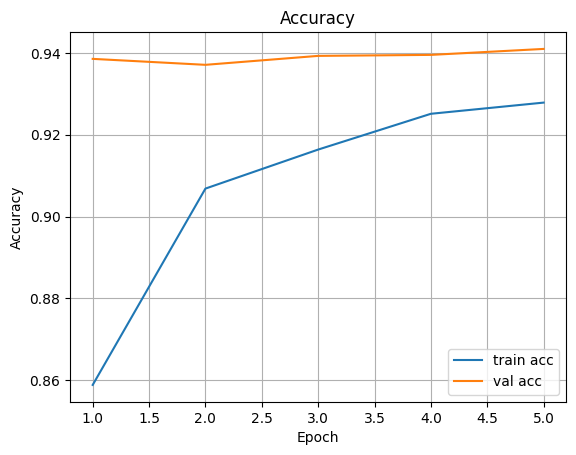

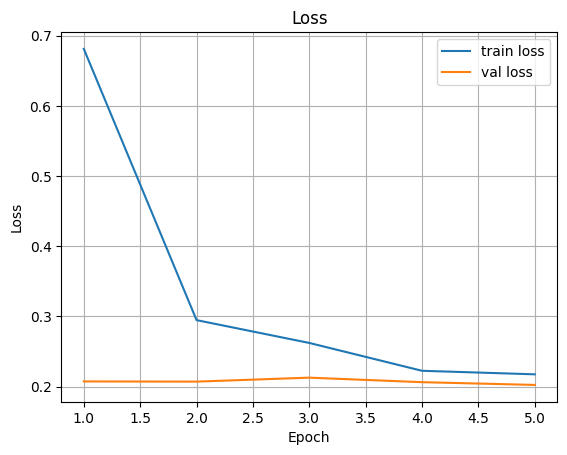

In [20]:
# Cellule — Courbes d'entraînement (à exécuter après le fit)
import matplotlib.pyplot as plt

def plot_history(h):
    acc      = h.history.get("accuracy", [])
    val_acc  = h.history.get("val_accuracy", [])
    loss     = h.history.get("loss", [])
    val_loss = h.history.get("val_loss", [])
    epochs   = range(1, len(acc) + 1)

    # Accuracy
    plt.figure()
    plt.plot(epochs, acc, label="train acc")
    plt.plot(epochs, val_acc, label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(epochs, loss, label="train loss")
    plt.plot(epochs, val_loss, label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_head)


In [8]:
model.save("model.h5")

In [9]:
# Cellule 7 — Chargement model.h5 avec couche custom "Cast"
import tensorflow as tf

class Cast(tf.keras.layers.Layer):
    def __init__(self, dtype="float32", **kwargs):
        super().__init__(**kwargs)
        self.target_dtype = tf.as_dtype(dtype)
    def call(self, inputs):
        return tf.cast(inputs, self.target_dtype)
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"dtype": self.target_dtype.name})
        return cfg

MODEL_PATH = "model.h5"
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={"Cast": Cast},
    compile=False  # évite d'exiger des objets custom d'optimizer/perte
)
print("Modèle chargé depuis:", MODEL_PATH)


Modèle chargé depuis: model.h5


In [10]:
# Recompile le modèle avant évaluation
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
# Cellule 8 — Évaluation rapide sur la validation
loss, acc = model.evaluate(val_ds, verbose=0)
print(f"Validation — loss: {loss:.4f} | acc: {acc:.4f}")


Validation — loss: 0.2025 | acc: 0.9410


Classe prédite: Bull Mastiff
Confiance: 0.9864827990531921


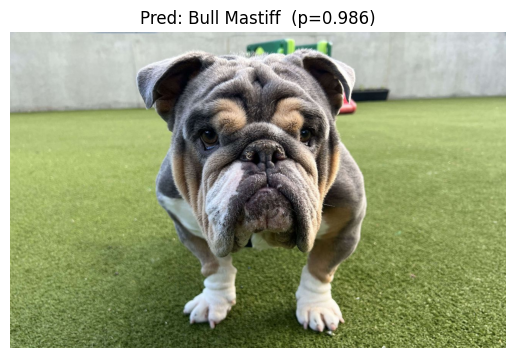

In [18]:
# Cellule — Prédiction sur une image déjà dans Kaggle
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

# chemin vers ton image (exemple)
img_path = "/kaggle/input/dogs-abdel/test/bouleddogues/bouleddogues3.jpeg"

# préparation
img = load_img(img_path, target_size=IMG_SIZE)
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# prédiction
probs = model.predict(x, verbose=0)[0]
pred_idx = np.argmax(probs)

print("Classe prédite:", prettify(class_names[pred_idx]))
print("Confiance:", float(probs[pred_idx]))

# affichage
plt.imshow(load_img(img_path))
plt.axis("off")
plt.title(f"Pred: {prettify(class_names[pred_idx])}  (p={probs[pred_idx]:.3f})")
plt.show()


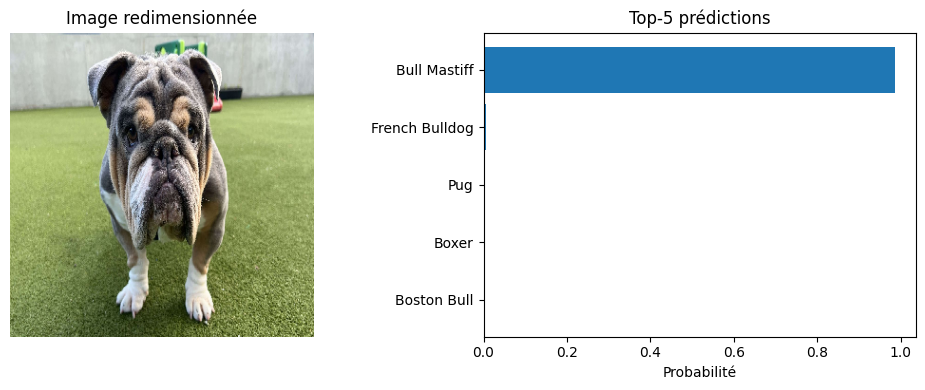

In [16]:
# Cellule — Affichage image + Top-5 en diagramme (corrigé)
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import img_to_array

# convertir l'image PIL en array pour imshow
img_array = img_to_array(img).astype("uint8")

# récupérer les Top-5
TOPK = 5
topk_idx = np.argsort(probs)[::-1][:TOPK]
topk_labels = [prettify(class_names[i]) for i in topk_idx]
topk_probs = [probs[i] for i in topk_idx]

# créer la figure
plt.figure(figsize=(10,4))

# 1) image redimensionnée
plt.subplot(1,2,1)
plt.imshow(img_array.astype("uint8"))
plt.axis("off")
plt.title("Image redimensionnée")

# 2) diagramme barres
plt.subplot(1,2,2)
plt.barh(topk_labels[::-1], topk_probs[::-1])  # inversé pour mettre la + grande en haut
plt.xlabel("Probabilité")
plt.title("Top-5 prédictions")

plt.tight_layout()
plt.show()
